In [1]:
%load_ext autoreload
%autoreload 2

In [258]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.optimize import linprog

from conditionalconformal import CondConf

ModuleNotFoundError: No module named 'seaborn'

  0%|          | 0/50 [00:00<?, ?it/s]

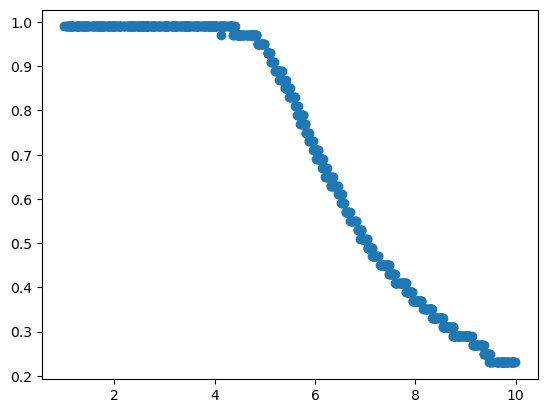

In [382]:
def generate_dataset(rng, n, p):
    x = rng.uniform(low=1, high=10, size=(n,1))
    if p > 1:
        x_noise = rng.uniform(low=5, high=10, size=(n,p - 1))
        x = np.concatenate((x, x_noise), axis=1)
    y = rng.normal(scale=x[:,0]**3)
    return x, y

def split_dataset(dataset, rng, train_frac = 0.8):
    x, y = dataset
    ind = np.arange(len(x))
    rng.shuffle(ind)

    train_num = int(train_frac * len(x))
    train_ind = ind[0:train_num]
    calib_ind = ind[train_num:]
    
    data_train = (x[train_ind], y[train_ind])
    data_calib = (x[calib_ind], y[calib_ind])
    return data_train, data_calib

rng = np.random.default_rng(seed=0)
n = 2000 # was 300
p = 2

dataset = generate_dataset(rng, n, p)
data_calib, data_test = split_dataset(dataset, rng, train_frac=0.5)

x_calib, y_calib = data_calib

score_fn = lambda x, y: np.abs(y)
phi_fn = lambda x: np.concatenate((np.ones((len(x), 1)), x, x**2), axis=1)
condconf = CondConf(score_fn = score_fn, Phi_fn = phi_fn)
condconf.setup_problem(x_calib, y_calib)

# lengths = np.empty((100, len(x_calib)))
# quantile_grid = np.linspace(0.01, 1, 100)
# for i, q in enumerate(quantile_grid):
#     duals, primals = condconf._get_calibration_solution(quantile=q)
#     cutoffs = phi_fn(x_calib) @ primals
#     lengths[i] = 2 * cutoffs.flatten()

x_test, y_test = data_test
n_grid = 50
lengths = np.empty((n_grid, len(x_test)))
quantile_grid = np.linspace(0.01, 0.99, n_grid)
i = 0
for q in tqdm(quantile_grid):
    lengths_q = []
    for x_t in x_test:
        cutoff = condconf.predict(quantile=q, x_test=x_t.reshape(1,-1), score_inv_fn = lambda c, x: c, randomize=False)
        lengths_q.append(2 * cutoff[0])
    lengths[i] = lengths_q
    i += 1 

length_booleans = lengths < 500

first_violating_indices = np.argmax(~length_booleans, axis=0) - 1
first_violating_indices[~np.any(~length_booleans, axis=0)] = -1  # Use -1 to indicate no False found

max_quantiles = quantile_grid[first_violating_indices]

# truncate the alpha estimate?
# max_quantiles = np.clip(max_quantiles, a_max=0.95, a_min=0)

phi_alpha = lambda x: np.concatenate((np.ones((len(x), 1)), x, x**2, x**3), axis=1)
condconf_alpha = CondConf(score_fn = lambda x, y: y, Phi_fn = phi_alpha)
condconf_alpha.setup_problem(x_calib, max_quantiles)
_, primals = condconf_alpha._get_calibration_solution(quantile=0.01)

quantile_fn = lambda x: phi_alpha(x) @ primals

# import xgboost as xgb
# model = xgb.XGBRegressor(objective='reg:logistic', n_estimators=100, learning_rate=0.1, max_depth=3)
# model.fit(x_calib, max_quantiles)
# quantile_fn = lambda x: model.predict(x)
# plt.scatter(x_calib[:,0], model.predict(x_calib))
# plt.scatter(x_calib[:,0], quantile_fn(x_calib))
plt.scatter(x_test[:,0], max_quantiles)

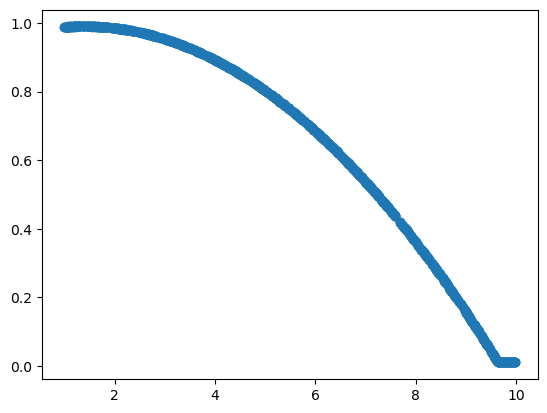

In [383]:
phi_alpha = lambda x: np.concatenate((np.ones((len(x), 1)), x, x**2), axis=1)
condconf_alpha = CondConf(score_fn = lambda x, y: y, Phi_fn = phi_alpha)
condconf_alpha.setup_problem(x_test, max_quantiles)
_, primals = condconf_alpha._get_calibration_solution(quantile=0.2)

quantile_fn = lambda x: np.clip(phi_alpha(x) @ primals, a_min=0.01, a_max=0.99)

plt.scatter(x_calib[:,0], quantile_fn(x_calib))


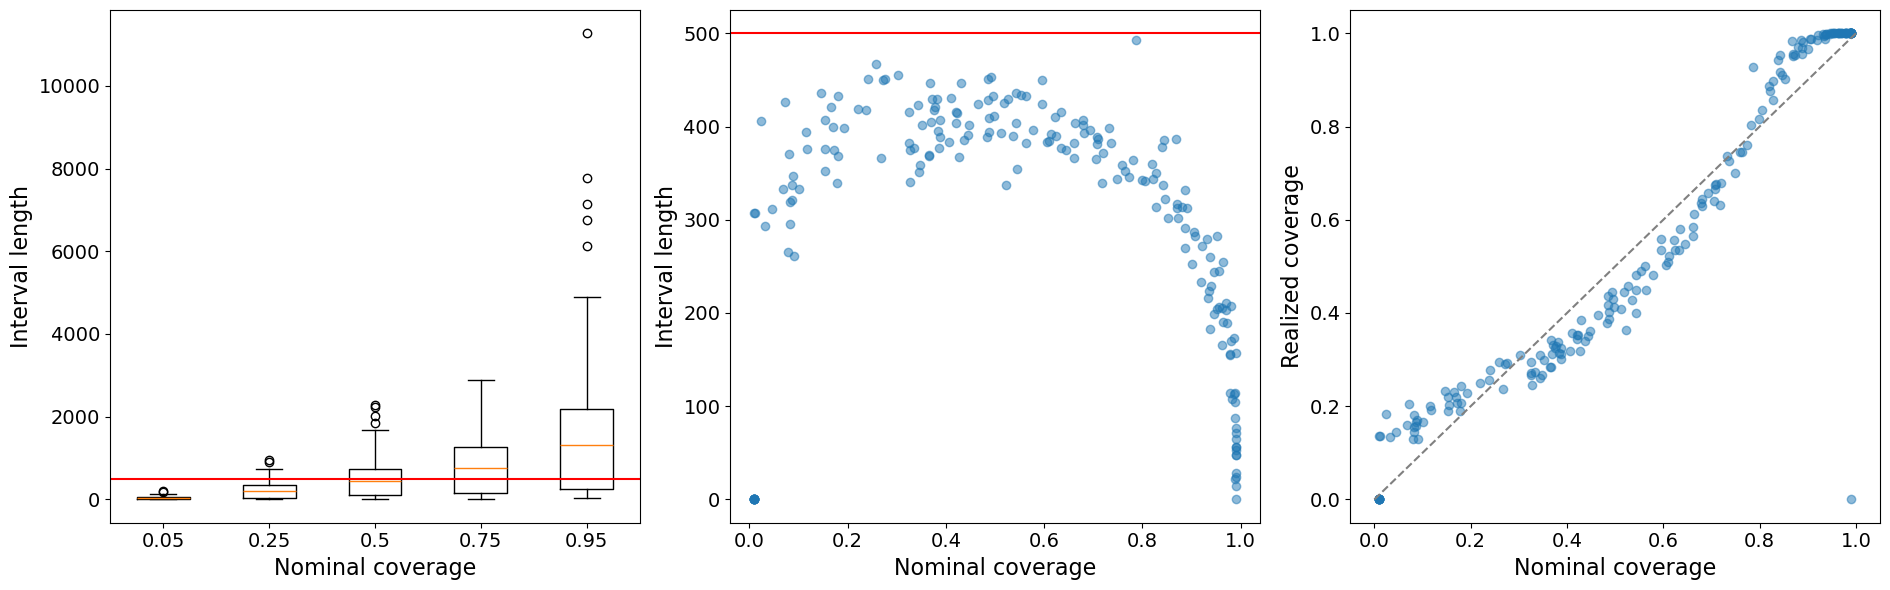

In [420]:
# seed = 1
# nominal = []
# realized = []
# lengths = []
# lengths_xlarge = []
# lengths_large = []
# lengths_medium = []
# lengths_small = []
# lengths_xsmall = []
# xs = []
# for seed in tqdm(range(200)):
#     rng = np.random.default_rng(seed=seed)
#     n = 1000
    
#     dataset = generate_dataset(rng, n, p)
#     data_calib, data_test = split_dataset(dataset, rng, train_frac=1)
    
#     x_calib, y_calib = data_calib
#     score_fn = lambda x, y: np.abs(y)
#     phi_fn = lambda x : np.concatenate((np.ones((len(x), 1)), x, x**2, quantile_fn(x).reshape(-1,1)), axis=1)
#     condconf = CondConf(score_fn = score_fn, Phi_fn = phi_fn, quantile_fn = quantile_fn)
#     condconf.setup_problem(x_calib, y_calib)
    
#     x_test, y_test = generate_dataset(rng, 1, p) 
#     raw_cutoffs = []
#     raw_cutoff = condconf.predict(quantile=None, x_test=x_test, score_inv_fn = lambda c, x: c, randomize=False)
#     raw_cutoffs.append(max(raw_cutoff[0], 0))
#     lengths.append(2 * raw_cutoffs[0])

#     raw_cutoff_xlarge = condconf.predict(quantile=0.95, x_test=x_test, score_inv_fn = lambda c, x: c, randomize=False)
#     raw_cutoff_large = condconf.predict(quantile=0.75, x_test=x_test, score_inv_fn = lambda c, x: c, randomize=False)
#     raw_cutoff_medium = condconf.predict(quantile=0.5, x_test=x_test, score_inv_fn = lambda c, x: c, randomize=False)
#     raw_cutoff_small = condconf.predict(quantile=0.25, x_test=x_test, score_inv_fn = lambda c, x: c, randomize=False)
#     raw_cutoff_xsmall = condconf.predict(quantile=0.05, x_test=x_test, score_inv_fn = lambda c, x: c, randomize=False)
    
#     lengths_xlarge.append(2 * max(raw_cutoff_xlarge[0], 0))
#     lengths_large.append(2 * max(raw_cutoff_large[0], 0))
#     lengths_medium.append(2 * max(raw_cutoff_medium[0], 0))
#     lengths_small.append(2 * max(raw_cutoff_small[0], 0))
#     lengths_xsmall.append(2 * max(raw_cutoff_xsmall[0], 0))

#     pointwise_miscover_test = (1 - norm.cdf(raw_cutoffs, scale=x_test[:,0]**3)) * 2
#     xs.append(x_test.flatten())
#     nominal.append(condconf.quantile_fn(x_test))
#     realized.append(1 - pointwise_miscover_test)
#     if np.abs(realized[-1] - nominal[-1]) > 0.3:
#         print(raw_cutoff, realized[-1], nominal[-1])
    
max_len = 500
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 6))
# ax1.axhline(max_len, color='red')
ax1.boxplot([lengths_xsmall, lengths_small, lengths_medium, lengths_large, lengths_xlarge])
ax1.set_xticklabels([0.05, 0.25, 0.5, 0.75, 0.95])
ax1.axhline(max_len, color='red')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xlabel("Nominal coverage", fontsize=16)
ax1.set_ylabel("Interval length", fontsize=16)
ax2.axhline(max_len, color='red')
ax2.scatter(nominal, lengths, alpha=0.5)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.set_xlabel("Nominal coverage", fontsize=16)
ax2.set_ylabel("Interval length", fontsize=16)
ax3.scatter(nominal, realized, alpha=0.5)
ax3.tick_params(axis='both', which='major', labelsize=14)
ax3.set_xlabel("Nominal coverage", fontsize=16)
ax3.set_ylabel("Realized coverage", fontsize=16)
ax3.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), '--', color='grey')
plt.tight_layout()
plt.savefig('figures/length_control_synthetic.pdf')

# plt.hist(lengths)
# plt.scatter(model.predict(x_test), 1 - pointwise_miscover_test, s=0.3)
# print(np.mean(np.asarray(lengths) > 500))
# plt.figure()
# plt.scatter(np.asarray(xs)[:,0], lengths)

[1.96873289]
[-203.63153774  -44.53806139   -6.02169627   24.22696679    0.32326365
  259.47765465]
[8.33574094]


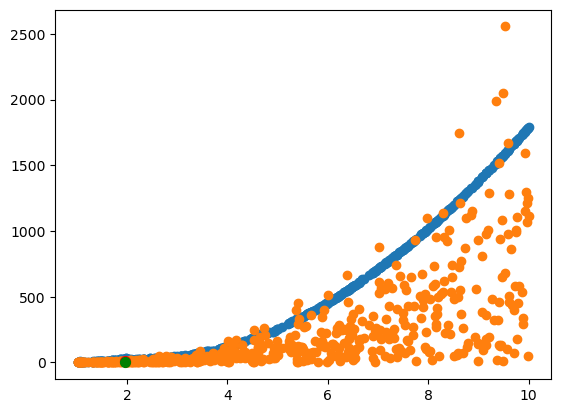

In [318]:
print(condconf.predict(quantile=None, x_test=x_test, score_inv_fn = lambda c, x: c, randomize=False))
bounds = [(0.95 - 1, 0.95)] * len(condconf.scores_calib)
zeros = np.zeros((condconf.phi_calib.shape[1],))
res = linprog(-1 * condconf.scores_calib, A_eq=condconf.phi_calib.T, b_eq=zeros, bounds=bounds, method='highs')
print(-1 * res.eqlin.marginals)
plt.scatter(condconf.x_calib[:,0], -1 * condconf.phi_calib @ res.eqlin.marginals)
plt.scatter(condconf.x_calib[:,0], condconf.scores_calib)
# print(x_test.shape, y_test.shape)
plt.scatter(x_test[:,0], np.abs(y_test), color='red', s=50)
plt.scatter(x_test[:,0], condconf.predict(quantile=None, x_test=x_test, score_inv_fn = lambda c, x: c, randomize=False), 
            color='green', s=50)


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0.5003066696824569
0.5003066696824569


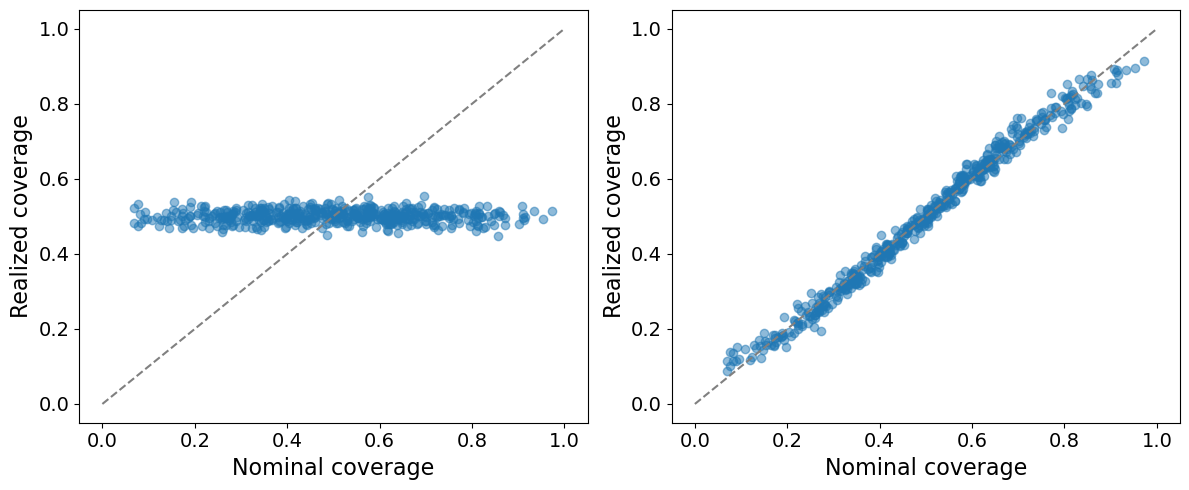

In [422]:
from scipy.stats import norm
from scipy.special import expit

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

realized = []
nominal = []
for seed in tqdm(range(500)):
    rng = np.random.default_rng(seed=seed)
    S = rng.standard_normal(size=(1000,1))
    x = rng.standard_normal(size=(1000,1))
    quantile = expit(x)
    Phi = np.concatenate((np.ones_like(S),), axis=1)
    if quantile[-1] > 0.5:
        S[-1] = 10
    else:
        S[-1] = -10
    if type(quantile) == np.ndarray:
        bounds = np.concatenate((quantile - 1, quantile), axis=1)
    else:
        bounds = np.asarray([quantile - 1, quantile])
        bounds = np.tile(bounds.reshape(1,-1), (len(S), 1))
    zeros = np.zeros((Phi.shape[1],))
    res = linprog(-1 * S, A_eq=Phi.T, b_eq=zeros, bounds=bounds, method='highs')
    
    guess = Phi[-1].reshape(-1,1).T @ (-1 * res.eqlin.marginals.reshape(-1,1))
    realized.append(norm.cdf(guess))
    nominal.append(quantile[-1])

ax1.scatter(nominal, realized, alpha=0.5)
ax1.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), '--', color='grey')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xlabel("Nominal coverage", fontsize=16)
ax1.set_ylabel("Realized coverage", fontsize=16)

realized = []
nominal = []
for seed in tqdm(range(500)):
    rng = np.random.default_rng(seed=seed)
    S = rng.standard_normal(size=(1000,1))
    x = rng.standard_normal(size=(1000,1))
    quantile = expit(x)
    Phi = np.concatenate((np.ones_like(S),quantile), axis=1)
    if quantile[-1] > 0.5:
        S[-1] = 10
    else:
        S[-1] = -10
    if type(quantile) == np.ndarray:
        bounds = np.concatenate((quantile - 1, quantile), axis=1)
    else:
        bounds = np.asarray([quantile - 1, quantile])
        bounds = np.tile(bounds.reshape(1,-1), (len(S), 1))
    zeros = np.zeros((Phi.shape[1],))
    res = linprog(-1 * S, A_eq=Phi.T, b_eq=zeros, bounds=bounds, method='highs')
    
    guess = Phi[-1].reshape(-1,1).T @ (-1 * res.eqlin.marginals.reshape(-1,1))
    realized.append(norm.cdf(guess))
    nominal.append(quantile[-1])

ax2.scatter(nominal, realized, alpha=0.5)
ax2.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), '--', color='grey')
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.set_xlabel("Nominal coverage", fontsize=16)
ax2.set_ylabel("Realized coverage", fontsize=16)
print(np.mean(realized))

plt.tight_layout()
plt.savefig('figures/synthetic_feature_comp.pdf')
print(np.mean(realized))

In [424]:
np.linspace(0.65, 0.9, 11)

array([0.65 , 0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 ,
       0.875, 0.9  ])